# Comparing Randomization Schemes

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from lolopy.learners import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor as SKRFRegressor
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd

## Load the data

In [2]:
header_names=["nRow", "noiseTrain", "noiseTest", "nBag", "jackknife", "recalibration", "rmse", "stdconf", "ucorr", "stdres"]
keys = ["nRow", "nBag", "jackknife", "recalibration", "noiseTrain", "noiseTest"]
metrics = ["rmse", "stdconf", "ucorr", "stdres"]
types = {}
    
def load_data(file):
    df = pd.read_csv(file, header=None, names=header_names, dtype=types)
    grouped = df.groupby(by=keys, as_index=False)
    ans = grouped.mean()
    ans["count"] = grouped.count()[metrics[0]]
    for prop in metrics:
        ans["{} SEM".format(prop)] = np.sqrt(grouped.var()[prop] / (grouped.count()[prop] - 1))
    return ans

dat = load_data("full_data.csv")
avg_corr_jackknife = dat[dat["jackknife"]]["ucorr"].mean()
avg_corr_ensemble = dat[dat["jackknife"] != True]["ucorr"].mean()
print(avg_corr_ensemble, avg_corr_jackknife, avg_corr_ensemble - avg_corr_jackknife)

0.4193549122825911 0.37300208900549126 0.04635282327709983


In [3]:
def make_lc(df, training_noise=0.0, scaling=0, nRow=None):
    fig, axs = plt.subplots(4, 2)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if nRow == None:
        x = "nRow"
    else:
        x = "nBag"
    
    def extract(sub):
        jk = sub[(sub["jackknife"]) & (sub["recalibration"])]
        es = sub[(sub["jackknife"] != True) & (sub["recalibration"])]
        jk_raw = sub[(sub["jackknife"]) & (sub["recalibration"] != True)]
        return jk, es, jk_raw
        
    def single_plot(ax, jk, es, jk_raw, metric):
        ax.set_xscale('log')

        ax.errorbar(jk[x], jk[metric], yerr=jk[metric + " SEM"], fmt="o-", label="Jackknife", color=colors[0])
        ax.errorbar(es[x], es[metric], yerr=es[metric + " SEM"], fmt="o-", label="Ensemble", color=colors[1])
        ax.errorbar(jk_raw[x], jk_raw[metric], yerr=jk_raw[metric + " SEM"], fmt="o--", label="JK Raw", color=colors[0])
    
    if scaling > 0:
        df = df[(df["nRow"] * scaling == df["nBag"])]
    else:
        if nRow == None:
            df = df[(df["nBag"] == 128)]
        else:
            df = df[(df["nRow"] == nRow)]
    
    sub_pred = df[(df["noiseTrain"] == training_noise) & (df["noiseTest"] == training_noise)].sort_values(by=x)
    sub_conf = df[(df["noiseTrain"] == training_noise) & (df["noiseTest"] == 0.0)].sort_values(by=x)

    jk, es, jk_raw = extract(sub_conf)
    #print(sub_pred)

    single_plot(axs[0][0], jk, es, jk_raw, "rmse")
    single_plot(axs[1][0], jk, es, jk_raw, "stdconf")
    single_plot(axs[2][0], jk, es, jk_raw, "ucorr")
    single_plot(axs[3][0], jk, es, jk_raw, "stdres")
    axs[0][0].legend()
    axs[0][0].set_yscale("log")
    axs[0][0].set_title("Confidence")

    jk, es, jk_raw = extract(sub_pred)
    
    single_plot(axs[0][1], jk, es, jk_raw, "rmse")
    single_plot(axs[1][1], jk, es, jk_raw, "stdconf")
    single_plot(axs[2][1], jk, es, jk_raw, "ucorr")
    single_plot(axs[3][1], jk, es, jk_raw, "stdres")
    axs[0][1].set_yscale("log")
    axs[0][1].set_title("Prediction")
    
    axs[0][0].set_ylabel("RMSE")
    axs[1][0].set_ylabel("Standard Confidence")
    axs[2][0].set_ylabel("Uncertainty Correlation")
    axs[3][0].set_ylabel("Standard Residual")
    axs[3][0].set_xlabel(x)
    axs[1][0].plot([16, max(es[x])], [0.68, 0.68], 'k--')
    axs[1][1].plot([16, max(es[x])], [0.68, 0.68], 'k--')
    axs[3][0].plot([16, max(es[x])], [1.0, 1.0], 'k--')
    axs[3][1].plot([16, max(es[x])], [1.0, 1.0], 'k--')
    

    rmse_min = df["rmse"].min()
    rmse_max = df["rmse"].max()
    print(rmse_min, rmse_max)
    for ax in axs[0]:
        ax.set_ylim(rmse_min*0.8, rmse_max*1.2)
    
    fig.set_size_inches(12, 9)
    fig.tight_layout()
    return fig

0.5567719999999999 2.485772


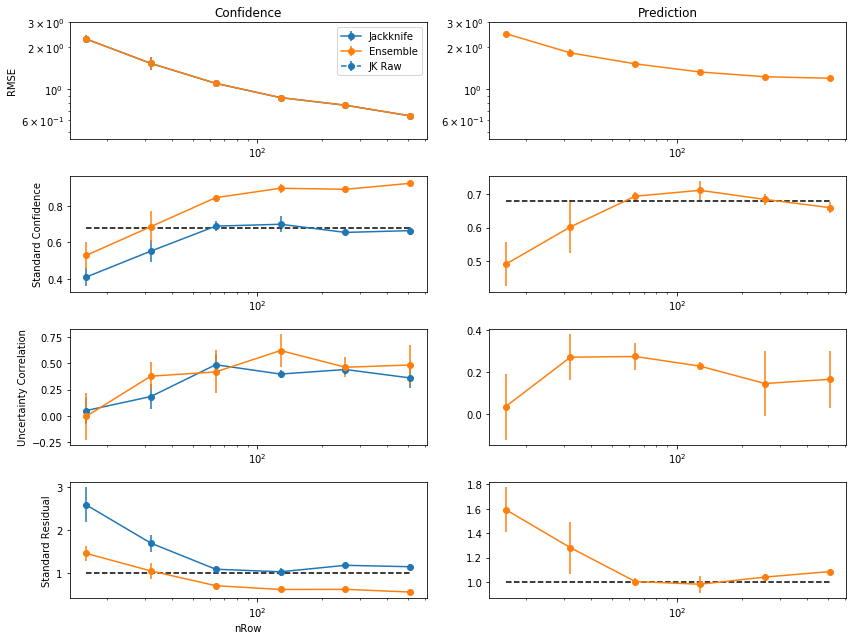

In [16]:
fig = make_lc(load_data("foo.csv"), training_noise=1.0, scaling=8)
# fig.savefig("lc_fs_no-noise.svg")
#load_data("no_floor_data.csv")

In [5]:
load_data("foo.csv")

,nRow,nBag,jackknife,recalibration,noiseTrain,noiseTest,rmse,stdconf,ucorr,stdres,count,rmse SEM,stdconf SEM,ucorr SEM,stdres SEM
0,16,32,False,True,0.0,0.0,2.41990,0.48438,0.238665,1.57148,2,0.0,0.0,0.000276,0.0
1,16,32,False,True,1.0,0.0,2.60382,0.31055,0.296190,2.45928,1,NaN,NaN,NaN,NaN
2,16,32,False,True,1.0,1.0,2.75071,0.28125,0.180490,2.64923,1,NaN,NaN,NaN,NaN
3,16,32,True,True,0.0,0.0,2.41990,0.31055,0.282060,3.50284,2,0.0,0.0,0.001442,0.0
4,16,32,True,True,1.0,0.0,2.60382,0.37109,0.346710,2.53551,1,NaN,NaN,NaN,NaN
5,16,64,False,True,0.0,0.0,2.48767,0.34180,0.342795,2.11256,2,0.0,0.0,0.002934,0.0
6,16,64,False,True,1.0,0.0,2.46506,0.53320,0.236100,1.31163,1,NaN,NaN,NaN,NaN
7,16,64,False,True,1.0,1.0,2.62136,0.50977,0.135570,1.41846,1,NaN,NaN,NaN,NaN
8,16,64,True,True,0.0,0.0,2.48767,0.27148,0.352185,4.23585,2,0.0,0.0,0.006428,0.0
9,16,64,True,True,1.0,0.0,2.46506,0.27734,0.216100,3.15819,1,NaN,NaN,NaN,NaN
